In [ ]:
#pip install kaggle-cli
# kg download -u USERNAME -p PASSWORD -c dogs-vs-cats-redux-kernels-edition

In [ ]:
from utils import *
from vgg16 import Vgg16
from shutil import copyfile
%matplotlib inline

current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/redux'


1. Create Validation and Sample sets
2. Rearrange image files into their respective directories
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

Create Validation and Sample sets

In [ ]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir sample\train
%mkdir sample\test
%mkdir sample\valid
%mkdir sample\results
%mkdir test\unknown

In [ ]:
%cd $DATA_HOME_DIR\train

In [ ]:
# copy 2k samples from train dir to validation dir
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [ ]:
%cd $DATA_HOME_DIR/valid

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

#### Rearrange image files into their respective directories

In [ ]:
%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
!move cat.*.jpg cats/
!move dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
!move cat.*.jpg cats/
!move dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
!move cat.*.jpg cats/
!move dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
!move cat.*.jpg cats/
!move dog.*.jpg dogs/

In [ ]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
!move *.jpg unknown/

#### Finetuning and Training

In [ ]:
%cd $DATA_HOME_DIR

In [2]:
#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

In [3]:
vgg = Vgg16()
batch_size=16
no_of_epochs=3

In [4]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 784s - loss: 0.1603 - acc: 0.9705 - val_loss: 0.1103 - val_acc: 0.9770
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 783s - loss: 0.1504 - acc: 0.9771 - val_loss: 0.1160 - val_acc: 0.9810
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 783s - loss: 0.1462 - acc: 0.9787 - val_loss: 0.1197 - val_acc: 0.9810
Completed 3 fit operations


#### Generate Predictions

In [6]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [7]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  8.3498e-17   1.0000e+00]
 [  1.0000e+00   8.2575e-25]
 [  1.0000e+00   7.9048e-18]
 [  1.7229e-21   1.0000e+00]
 [  4.5200e-10   1.0000e+00]]
['unknown\\1.jpg', 'unknown\\10.jpg', 'unknown\\100.jpg', 'unknown\\1000.jpg', 'unknown\\10000.jpg']


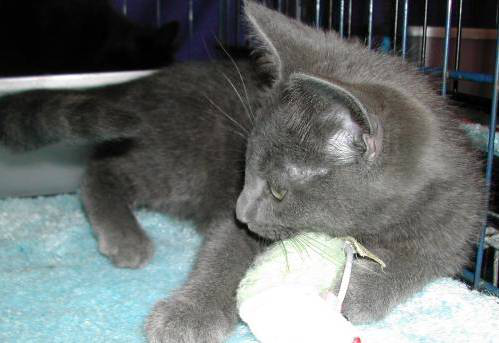

In [8]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [9]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

#### Validate Predictions

In [10]:
#vgg.model.load_weights(results_path+latest_weights_filename)
vgg.model.load_weights(results_path+latest_weights_filename)
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [11]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [12]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

found 1961 correct labels


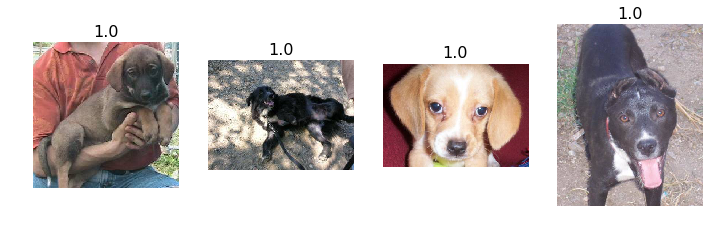

In [17]:
# let's look at a few correct labels
correct_labels = np.where(our_labels == expected_labels)[0]
print "found %d correct labels" % len(correct_labels)
idx = permutation(correct_labels)[:n_view]
plots_idx(idx, our_predictions[correct_labels])

found 39 incorrect labels


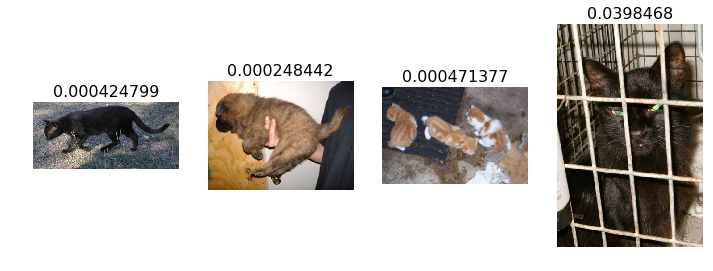

In [21]:
# incorrect labels
incorrect_labels = np.where(our_labels != expected_labels)[0]
print "found %d incorrect labels" % len(incorrect_labels)
idx = permutation(incorrect_labels)[:n_view]
plots_idx(idx, our_predictions[incorrect_labels])

found 1037 our most confident cat predictions that are actually cats


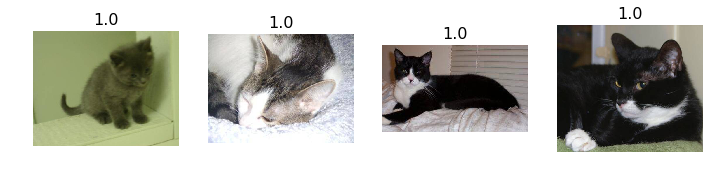

In [28]:
# true label
# cat -  0
# dog - 1 
# our most confident cat predictions that are actually cats
correct_cats = np.where(our_labels ==0 & (our_labels == expected_labels))[0]
print "found %d our most confident cat predictions that are actually cats" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

found 966 our most confident dog predictions that are actually dogs


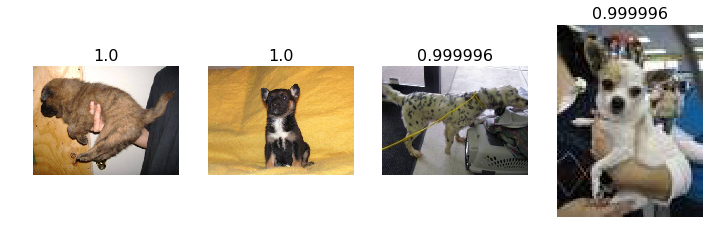

In [29]:
# our most confident dog predictions that are actually dogs
correct_dogs = np.where(our_labels ==1 & (our_labels == expected_labels))[0]
print "found %d our most confident dog predictions that are actually dogs" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[::-1][:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

found 1037 our most confident cat predictions that are actually not  cats


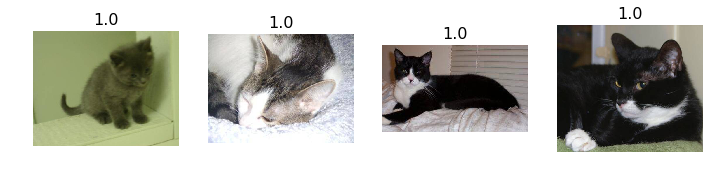

In [30]:
# our most confident cat predictions that are actually not cats
incorrect_cats = np.where(our_labels ==0 & (our_labels != expected_labels))[0]
print "found %d our most confident cat predictions that are actually not  cats" % len(incorrect_cats)
most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats]) 

found 1034 our most confident dog predictions that are actually not  dogs


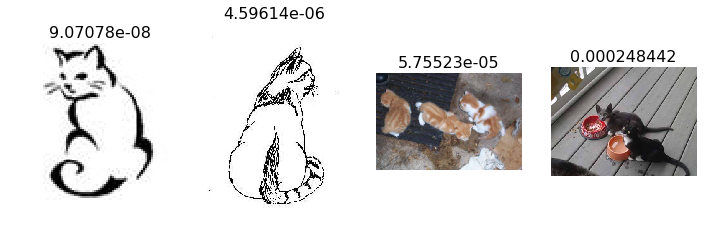

In [32]:
# our most confident dog predictions that are actually not dogs
incorrect_dogs = np.where(our_labels ==1 & (our_labels != expected_labels))[0]
print "found %d our most confident dog predictions that are actually not  dogs" % len(incorrect_dogs)
most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

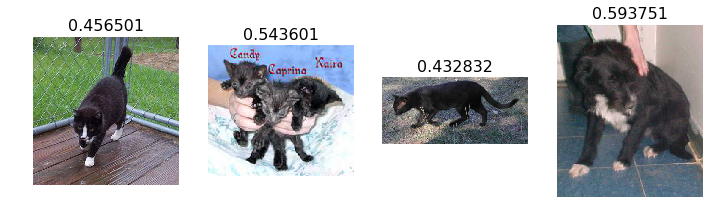

In [33]:
# most uncertain labels
most_uncertain = np.argsort(np.abs(our_predictions-0.5))[:n_view]
plots_idx(most_uncertain, our_predictions[most_uncertain])

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[1016   18]
 [  21  945]]


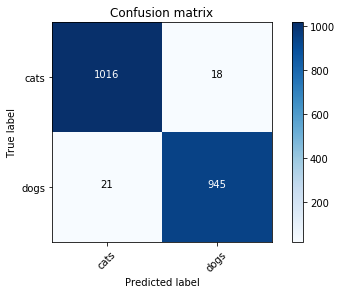

In [35]:
plot_confusion_matrix(cm, val_batches.class_indices)

#### submit predicitons to kaggle 
submission format: <br>
imageId,isDog <br>
1242, 0.3984  <br>
3947, 0.1000 <br>
4539, 0.9082  <br>
2345, 0.0000   <br>


kaggle evaluation metric : log loss

In [40]:
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')
isDog = preds[:,1]

In [41]:
#log loss rewards predictions that are confident and correct (p=.9999,label=1),
#but it punishes predictions that are confident and wrong far more (p=.0001,label=1). 
# let's lower bound the prediction by 0.05 and upper bound by 0.95
isDog = isDog.clip(min=0.05, max=0.95)

In [48]:
# extract ids from the filename
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

[   1   10  100 ..., 9997 9998 9999]


In [49]:
submission = np.stack([ids,isDog],axis =1)

In [ ]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission_final.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')